# N starvation 

## Which N sources allow MED4 to grow

check out Escher visualization https://escher.readthedocs.io/en/latest/getting_started.html

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import numpy as np
import seaborn as sns
import itertools
from matplotlib.colors import LogNorm, Normalize


In [2]:
import subprocess
import time


In [3]:
from cobra.flux_analysis import flux_variability_analysis
from cobra.flux_analysis import production_envelope


In [4]:
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)

In [5]:
sns.hls_palette

<function seaborn.palettes.hls_palette(n_colors=6, h=0.01, l=0.6, s=0.65, as_cmap=False)>

In [6]:
# values from Ofaim at el.

PARAMETER_VALUES = [#"Name",     "Reaction ID",          "Lower bound", "UpperBound"
                   ["HCO3",      "HCO3EXcar",            -8,            0],
                   #["Nitrogen",  "AmmoniaEX",            -0.56,         0],
                   #["Phosphate", "FAKEOrthophosphateEX", -0.1,          0],
                   ["Light",     "LightEX",              -150,          0]]
CO2MAX = 0.82

# Block fake reactions
FAKE_TRANSPORT = ["AminosugarsOUT", "FAKEAAOUT", "FAKEABPOUT", "FAKEacpTRANS", "FAKEApoacpTRANS", "FAKEThioredoxinTRANS", 
                  "FreefattyacidsOUT", "7NMeth7carbOUT", "ArtificialproteinOUT", "FADOUT", "LipoylproteinTRANS", "MenaquinoneOUT", 
                  "NicotinateOUT", "THFpolyglutOUT", "Thiamin_dpOUT"]


In [7]:
def get_elements(rid):
    r = model.reactions.get_by_id(rid)
    m = r.reactants[0]    
    elements = m.elements.copy()
    
    res = {
        'reaction' : rid,
        'metabolite' : m.name,
        'mid': m.id,
        'N' : 'N' in elements,
        'C' : 'C' in elements,
        
    }
    return pd.Series(res)

# Import model and manipulate based on Ofaim at el

In [8]:
import os
model_dpath = os.path.join('..', 'Model_files')
model_fname = 'iSO595v7_with_formula.xml'
model_fpath = os.path.join(model_dpath, model_fname)


In [9]:
model = cobra.io.read_sbml_model(model_fpath)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-13


In [10]:
# manipulations copied from Ofaim at el.

remove_blocked = False

# Block H2S
model.reactions.H2SEX.lower_bound = 0

# Block fake transports
for rid in FAKE_TRANSPORT:
    model.reactions.get_by_id(rid).bounds = (0,0)

# Remove blocked reactions
if remove_blocked:
    blocked = cobra.flux_analysis.find_blocked_reactions(model, open_exchanges = True)
    print('blocked', len(blocked), blocked)
    model.remove_reactions([model.reactions.get_by_id(r_id) for r_id in blocked])

# Block maximum CO2 production
model.reactions.CO2EX.bounds = (0, CO2MAX)

for i, row in enumerate(PARAMETER_VALUES):
    # Row: Name, Reaction ID, lower bound, upper bound
    key = row[0]
    reaction_id = row[1]
    lower_bound = row[2]
    upper_bound = row[3]
    r = model.reactions.get_by_id(reaction_id)
    # Fix flux
    r.bounds = (lower_bound, upper_bound)

In [11]:
exchange_ids = [r.id for r in model.exchanges] # + ["R00024"]

In [12]:
print('reactions', len(model.reactions))
print('metabolites', len(model.metabolites))
print('genes', len(model.genes))

reactions 994
metabolites 802
genes 595


In [13]:
model

Name,COBRAModel
Memory address,0x07f831d57ff40
Number of metabolites,802
Number of reactions,994
Number of groups,55
Objective expression,1.0*BIOMASS - 1.0*BIOMASS_reverse_69053
Compartments,"Cytoplasm, Extracellular, unknownCompartment2, Periplasm, unknownCompartment5"


In [14]:
model.metabolites.get_by_id('Carbamate[c]')

Metabolite identifier,Carbamate[c]
Name,Carbamate
Memory address,0x7f831d51cdf0
Formula,CH3NO2
Compartment,c
In 4 reaction(s),"R03546, R01395, R10949, R07316"


In [15]:
cobra.Configuration()

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,11
cache_directory,Path for the model cache,/home/oweissberg/.cache/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


In [16]:
model.reactions.get_by_id('PyruvateEX')

Reaction identifier,PyruvateEX
Name,PyruvateEX
Memory address,0x7f831cfc2550
Stoichiometry,Pyruvate[e] --> Pyruvate[e] -->
GPR,
Lower bound,0.0
Upper bound,1000.0


In [17]:
model.reactions.get_by_id('AmmoniaEX')

Reaction identifier,AmmoniaEX
Name,Ammonia Exchange
Memory address,0x7f831d016670
Stoichiometry,Ammonia[e] <=> Ammonia <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [18]:
model.reactions.get_by_id('LightEX')

Reaction identifier,LightEX
Name,Light Exchange
Memory address,0x7f831d020430
Stoichiometry,Photon[e] <-- Photon <--
GPR,
Lower bound,-150
Upper bound,0


In [19]:
model.reactions.get_by_id('BIOMASS')

Reaction identifier,BIOMASS
Name,Biomass formation
Memory address,0x7f831d34e550
Stoichiometry,104.0 ATP[c] + 0.0324116276714271 BioPool[c] + 0.0268408791654006 Bmineral[c] + 0.0559910868023904 Cell_wall[c] + 0.00111921401802897 Free_nucleic_acids[c] + 104.0 H2O[c] + 0.649245416793275... 104.0 ATP + 0.0324116276714271 BioPool + 0.0268408791654006 Trace metals and minerals + 0.0559910868023904 Cell wall Biomass precursor + 0.00111921401802897 Free nucleic acids + 104.0 H2O +...
GPR,
Lower bound,0.0
Upper bound,1000.0


# Identify N sources where MED4 grows on

In [20]:
model.medium

{'AmmoniaEX': 1000.0,
 'CadmiumEX': 1000.0,
 'CalciumEX': 1000.0,
 'ChlorideEX': 1000.0,
 'CobaltEX': 1000.0,
 'CopperEX': 1000.0,
 'FAKEOrthophosphateEX': 1000.0,
 'H2OEX': 1000.0,
 'HCO3EXcar': 8,
 'HEX': 1000.0,
 'IronEX': 1000.0,
 'LightEX': 150,
 'MagnesiumEX': 1000.0,
 'MolybdenumEX': 1000.0,
 'O2EX': 1000.0,
 'PotassiumEX': 1000.0,
 'SelenateEX': 1000.0,
 'SodiumEX': 1000.0,
 'StrontiumEX': 1000.0,
 'SulfateEX': 1000.0,
 'ZincEX': 1000.0,
 'H2O2EX': 1000.0}

In [21]:
# what are the metabolites in the medium?
df_medium = pd.DataFrame({'mediumExchange' : model.medium.keys()})
df_medium = pd.DataFrame.from_records(df_medium.mediumExchange.apply(get_elements))


In [22]:
df_medium

,reaction,metabolite,mid,N,C
0,AmmoniaEX,Ammonia,Ammonia[e],True,False
1,CadmiumEX,Cadmium,Cadmium[e],False,False
2,CalciumEX,Ca2+,Calcium_cation[e],False,False
3,ChlorideEX,Cl-,Chloride_ion[e],False,False
4,CobaltEX,Cobalt ion,Cobalt_ion[e],False,False
5,CopperEX,Copper,Copper[e],False,False
6,FAKEOrthophosphateEX,Orthophosphate,Orthophosphate[e],False,False
7,H2OEX,H2O,H2O[e],False,False
8,HCO3EXcar,HCO3-,HCO3[e],False,True
9,HEX,H+,H[e],False,False


In [23]:
df_medium.metabolite.unique()

array(['Ammonia', 'Cadmium', 'Ca2+', 'Cl-', 'Cobalt ion', 'Copper',
       'Orthophosphate', 'H2O', 'HCO3-', 'H+', 'Fe2+', 'Photon',
       'Magnesium cation', 'Molybdenum', 'O2', 'K+', 'Selenate', 'Na+',
       'Strontium cation', 'Sulfate', 'Zn2+', 'Hydrogen peroxide'],
      dtype=object)

In [24]:
# try to each exchange one by one
results = list()

def _check_medium(met1, met2=None):
    with model:
        medium = model.medium
        medium["AmmoniaEX"] = 0.0
        medium[met1] = 1000.0
        model.medium = medium
        solution = model.optimize()
        return {'uptake' : met1, 'objective_value' : solution.objective_value}
results = [_check_medium(met) for met in exchange_ids]        

In [25]:
df = pd.DataFrame(results)

In [26]:
df_growing = df.loc[(df.objective_value > 1e-5), 
                    ['uptake','objective_value']
                   ].nlargest(n=1000, columns='objective_value').reset_index(drop=True)

In [27]:
tdf = pd.DataFrame.from_records(df_growing.uptake.apply(get_elements))
df_growing = pd.merge(df_growing, tdf, left_on='uptake', right_on='reaction')

In [28]:
# check that the media is correct

### N sources that MED4 can grow on 

In [29]:
df_growing

,uptake,objective_value,reaction,metabolite,mid,N,C
0,GuanosineEX,1.239447,GuanosineEX,Guanosine[e],Guanosine[e],True,True
1,L_AspartateEX,0.238582,L_AspartateEX,L-Aspartate,L_Aspartate[e],True,True
2,GlutathioneEX,0.137239,GlutathioneEX,Glutathione[e],Glutathione[e],True,True
3,L_GlutamineEX,0.121923,L_GlutamineEX,L-Glutamine,L_Glutamine[e],True,True
4,L_SerineEX,0.118972,L_SerineEX,L-Serine,L_Serine[e],True,True
5,L_CystineEX,0.116452,L_CystineEX,L-Cystine,L_Cystine[e],True,True
6,L_AlanineEX,0.116452,L_AlanineEX,L-Alanine,L_Alanine[e],True,True
7,L_LeucineEX,0.103996,L_LeucineEX,L-Leucine,L_Leucine[e],True,True
8,GlycineEX,0.101626,GlycineEX,Glycine,Glycine[e],True,True
9,UreaEX,0.098462,UreaEX,Urea,Urea[e],True,True


### Even when all other potential mediums are available, MED4 does not grow

In [30]:
# open all additional mediums (all those that do not facilitate growth by themselves)
not_open_boundary_ids = [i for i in exchange_ids if (i not in model.medium) and (i not in df_growing.uptake.values)]
with model:
    medium = model.medium
    medium["AmmoniaEX"] = 0.0
    for i in not_open_boundary_ids:
        medium[i] = 1000.0
    model.medium = medium
    solution = model.optimize()
    print(model.summary())


Objective
1.0 BIOMASS = 0.0

Uptake
------
 Metabolite   Reaction   Flux  C-Number C-Flux
 Ethanol[e]  EthanolEX 0.1579         2 16.67%
Fumarate[e] FumarateEX 0.1579         4 33.33%
Glycogen[e] GlycogenEX 0.1579         6 50.00%
  Oxygen[e]       O2EX 0.8686         0  0.00%

Secretion
---------
Metabolite  Reaction    Flux  C-Number C-Flux
    CO2[e]     CO2EX -0.3159         1 16.67%
Citrate[e] CitrateEX -0.1579         6 50.00%
Formate[e] FormateEX -0.6317         1 33.33%
    H2O[e]     H2OEX -0.3159         0  0.00%



### Force MED4 to uptake the potential N sources, limit growth (biomass), and see what is secreted

In [31]:
def _force_feeding(met1):
    with model:
        medium = model.medium
        medium["AmmoniaEX"] = 0.0
        medium[met1] = 1000.0
        model.medium = medium
        model.reactions.get_by_id(met1).upper_bound = -1e-5
        model.reactions.BIOMASS.upper_bound = 1e-2
        solution = model.optimize()
        print(met1, model.summary())
        fluxes = flux_variability_analysis(model, model.boundary, loopless=True, fraction_of_optimum=0.9, processes=11)
        fluxes['uptake'] = met1
        return fluxes
fluxes_df_list = [_force_feeding(met1) for met1 in df_growing['uptake']]

GuanosineEX Objective
1.0 BIOMASS = 0.01

Uptake
------
         Metabolite             Reaction      Flux  C-Number C-Flux
         Cadmium[e]            CadmiumEX 4.827E-07         0  0.00%
  Calcium_cation[e]            CalciumEX 0.0002676         0  0.00%
    Chloride_ion[e]           ChlorideEX  0.002379         0  0.00%
      Cobalt_ion[e]             CobaltEX 1.552E-05         0  0.00%
          Copper[e]             CopperEX 8.734E-07         0  0.00%
  Orthophosphate[e] FAKEOrthophosphateEX  0.003633         0  0.00%
       Guanosine[e]          GuanosineEX    0.4954        10 98.71%
            HCO3[e]            HCO3EXcar   0.06454         1  1.29%
             Fe2[e]               IronEX 3.232E-05         0  0.00%
          Photon[e]              LightEX  0.001817         0  0.00%
Magnesium_cation[e]          MagnesiumEX  0.001589         0  0.00%
          Oxygen[e]                 O2EX     1.032         0  0.00%
               K[e]          PotassiumEX 0.0009516         0

L_GlutamineEX Objective
1.0 BIOMASS = 0.01

Uptake
------
         Metabolite             Reaction      Flux  C-Number C-Flux
         Cadmium[e]            CadmiumEX 4.827E-07         0  0.00%
  Calcium_cation[e]            CalciumEX 0.0002676         0  0.00%
    Chloride_ion[e]           ChlorideEX  0.002379         0  0.00%
      Cobalt_ion[e]             CobaltEX 1.552E-05         0  0.00%
          Copper[e]             CopperEX 8.734E-07         0  0.00%
  Orthophosphate[e] FAKEOrthophosphateEX  0.003633         0  0.00%
            HCO3[e]            HCO3EXcar    0.4507         1 58.16%
             Fe2[e]               IronEX 3.232E-05         0  0.00%
     L_Glutamine[e]        L_GlutamineEX   0.06483         5 41.84%
          Photon[e]              LightEX     11.52         0  0.00%
Magnesium_cation[e]          MagnesiumEX  0.001589         0  0.00%
               K[e]          PotassiumEX 0.0009516         0  0.00%
        Selenate[e]           SelenateEX 0.0007635        

L_AlanineEX Objective
1.0 BIOMASS = 0.01

Uptake
------
         Metabolite             Reaction      Flux  C-Number C-Flux
         Cadmium[e]            CadmiumEX 4.827E-07         0  0.00%
  Calcium_cation[e]            CalciumEX 0.0002676         0  0.00%
    Chloride_ion[e]           ChlorideEX  0.002379         0  0.00%
      Cobalt_ion[e]             CobaltEX 1.552E-05         0  0.00%
          Copper[e]             CopperEX 8.734E-07         0  0.00%
  Orthophosphate[e] FAKEOrthophosphateEX  0.003633         0  0.00%
            HCO3[e]            HCO3EXcar    0.2865         1 15.55%
             Fe2[e]               IronEX 3.232E-05         0  0.00%
       L_Alanine[e]          L_AlanineEX    0.5186         3 84.45%
          Photon[e]              LightEX     8.296         0  0.00%
Magnesium_cation[e]          MagnesiumEX  0.001589         0  0.00%
               K[e]          PotassiumEX 0.0009516         0  0.00%
        Selenate[e]           SelenateEX 0.0007635         0

UreaEX Objective
1.0 BIOMASS = 0.01

Uptake
------
         Metabolite             Reaction      Flux  C-Number C-Flux
         Cadmium[e]            CadmiumEX 4.827E-07         0  0.00%
  Calcium_cation[e]            CalciumEX 0.0002676         0  0.00%
    Chloride_ion[e]           ChlorideEX  0.002379         0  0.00%
      Cobalt_ion[e]             CobaltEX 1.552E-05         0  0.00%
          Copper[e]             CopperEX 8.734E-07         0  0.00%
  Orthophosphate[e] FAKEOrthophosphateEX  0.003633         0  0.00%
            HCO3[e]            HCO3EXcar    0.5425         1 92.59%
             Fe2[e]               IronEX 3.232E-05         0  0.00%
          Photon[e]              LightEX     12.39         0  0.00%
Magnesium_cation[e]          MagnesiumEX  0.001589         0  0.00%
               K[e]          PotassiumEX 0.0009516         0  0.00%
        Selenate[e]           SelenateEX 0.0007635         0  0.00%
   Sodium_cation[e]             SodiumEX  0.004461         0  0.0

CyanateEX Objective
1.0 BIOMASS = 0.01

Uptake
------
         Metabolite             Reaction      Flux  C-Number C-Flux
         Cadmium[e]            CadmiumEX 4.827E-07         0  0.00%
  Calcium_cation[e]            CalciumEX 0.0002676         0  0.00%
    Chloride_ion[e]           ChlorideEX  0.002379         0  0.00%
      Cobalt_ion[e]             CobaltEX 1.552E-05         0  0.00%
          Copper[e]             CopperEX 8.734E-07         0  0.00%
         Cyanate[e]            CyanateEX   0.08685         1 13.80%
  Orthophosphate[e] FAKEOrthophosphateEX  0.003633         0  0.00%
            HCO3[e]            HCO3EXcar    0.5425         1 86.20%
             Fe2[e]               IronEX 3.232E-05         0  0.00%
          Photon[e]              LightEX     12.39         0  0.00%
Magnesium_cation[e]          MagnesiumEX  0.001589         0  0.00%
               K[e]          PotassiumEX 0.0009516         0  0.00%
        Selenate[e]           SelenateEX 0.0007635         0  

In [32]:
force_feeding_df = pd.concat(fluxes_df_list)

In [33]:
force_feeding_df.index = force_feeding_df.index.set_names(['secretion'])
force_feeding_df = force_feeding_df.reset_index()
force_feeding_df.head()

,secretion,minimum,maximum,uptake
0,AminosugarsEX,0.0,0.0,GuanosineEX
1,FAKEAAEX,0.0,0.0,GuanosineEX
2,FAKEABPEX,0.0,0.0,GuanosineEX
3,FAKEacpEX,0.0,0.0,GuanosineEX
4,FAKEApoacpEX,0.0,0.0,GuanosineEX


In [34]:
force_feeding_df.loc[force_feeding_df.maximum > 1e-3].groupby('secretion').minimum.count()

secretion
4_AminobenzoateEX             16
4_Methyl_2_oxopentanoateEX    16
5_MethylthioadenosineEX       16
AcetateEX                     16
AdenineEX                     16
                              ..
ThiosulfateEX                 16
ThymidineEX                   16
UreaEX                        15
XanthosineEX                  16
tRNAEX                        16
Name: minimum, Length: 63, dtype: int64

In [35]:
drop_columns = ["tRNAEX", 'CadaverineEX', 'CadmiumEX','CalciumEX', 'ChlorideEX', 'CalciumEX', 'ChlorideEX',
                'IronEX','MagnesiumEX', 'PotassiumEX', 'SelenateEX', 'SodiumEX', 'StrontiumEX', 'ZincEX', 'R00024',
                'H2OEX', "HEX", 'BiomassEX', 'CO2EX', 'O2EX']
n_exchange_df = force_feeding_df.loc[(force_feeding_df.maximum > 1e-3) & 
                                     (~force_feeding_df.secretion.isin(drop_columns))
                                    ].reset_index(drop=True)
pdf = n_exchange_df.pivot_table(columns='uptake', index='secretion', values='maximum', fill_value=0)

In [36]:
tdf = n_exchange_df.uptake.apply(get_elements)
n_exchange_df[['metabolite_uptake', 'mid_uptake', 'N_uptake', 'C_uptake']] = tdf[['metabolite', 'mid', 'N', 'C']]

tdf = n_exchange_df.secretion.apply(get_elements)
n_exchange_df[['metabolite_secretion', 'mid_secretion','N_secretion', 'C_secretion']] = tdf[['metabolite','mid', 'N', 'C']]

n_exchange_df.head()

,secretion,minimum,maximum,uptake,metabolite_uptake,mid_uptake,N_uptake,C_uptake,metabolite_secretion,mid_secretion,N_secretion,C_secretion
0,B12EX,0.000000,7.941910,GuanosineEX,Guanosine[e],Guanosine[e],True,True,Cobamide coenzyme,Cobamide_coenzyme[e],True,True
1,BiotinEX,0.000000,1.985477,GuanosineEX,Guanosine[e],Guanosine[e],True,True,Biotin,Biotin[e],True,True
2,MethanolEX,0.000042,1.985519,GuanosineEX,Guanosine[e],Guanosine[e],True,True,Methanol,Methanol[e],False,True
3,SAdenosyl4methylthio2oxobutanoateEX,0.000042,1.985519,GuanosineEX,Guanosine[e],Guanosine[e],True,True,S-Adenosyl-4-methylthio-2-oxobutanoate,S_Adenosyl_4_methylthio_2_oxobutanoate[e],True,True
4,SMethyl5thioDriboseEX,0.000000,15.884229,GuanosineEX,Guanosine[e],Guanosine[e],True,True,S-Methyl-5-thio-D-ribose,S_Methyl_5_thio_D_ribose[e],False,True


In [37]:
col_anno = pd.DataFrame.from_records([get_elements(i) for i in pdf.columns])
row_anno = pd.DataFrame.from_records([get_elements(i) for i in pdf.index])
N_lut = {True: '#BF9270', False : '#FFEDDB'}
C_lut = {True: '#94B49F', False : '#FCF8E8'}
row_anno.N = row_anno.N.map(N_lut)
row_anno.C = row_anno.C.map(C_lut)
col_anno.N = col_anno.N.map(N_lut)
col_anno.C = col_anno.C.map(C_lut)
row_anno.index = row_anno.reaction
col_anno.index = col_anno.reaction

Text(0.5, 1, "Maximum FVA Flux - secretion when 'force fed'")

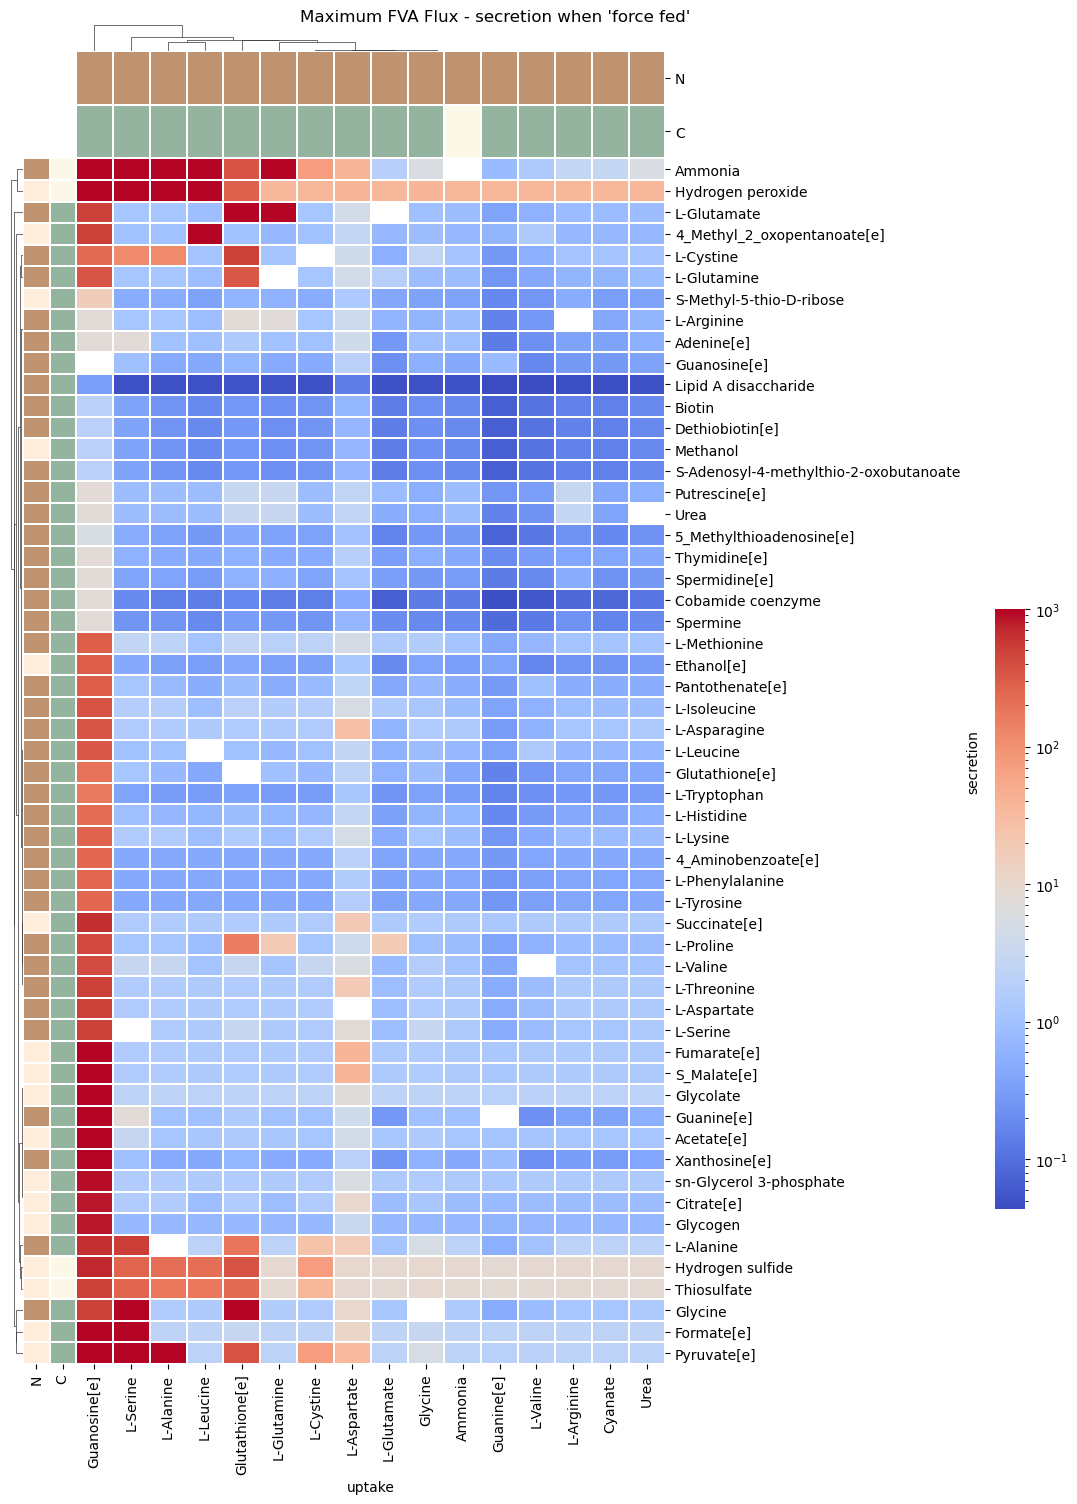

In [38]:

sns.clustermap(pdf, norm=LogNorm(), 
               cmap='coolwarm', figsize=(10,15), 
               linewidths=0.1, #cbar_kws= dict(location='right'),
               row_colors=row_anno[['N', 'C']],
               col_colors=col_anno[['N', 'C']],
               yticklabels= row_anno.metabolite,
               xticklabels= col_anno.metabolite,
               colors_ratio=0.04,
              robust=True, cbar_pos=(1, .2, .03, .4),
              dendrogram_ratio=0.02)
plt.suptitle("Maximum FVA Flux - secretion when 'force fed'", y=1)

In [39]:
len(exchange_ids)

101

In [40]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('data/PRO_N_sources.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
df_growing.to_excel(writer, sheet_name='uptake')
n_exchange_df.to_excel(writer, sheet_name='secretion')

# Close the Pandas Excel writer and output the Excel file.
writer.save()